# Введение

Цель эксперимента -- проверить эффективность линейных моделей для предсказания следующей ноты в midi файле.
1. Найти оптимальное число параметров линейной модели. В качестве параметров будут выступать ноты, идущие непосредственно перед предсказываемой. Функция потерь будет усредняться посредством кросс-валидации.
2. Для оптимального числа параметров найти минимальный размер выборки, достаточных для обучения.

Данные взяты с этого сайта: http://www.kunstderfuge.com/bach.htm

# Поиск числа параметров

In [21]:
import mido
import numpy as np

In [22]:
mid = mido.MidiFile("sample.mid")

In [23]:
notes = np.array([m.note for m in mid if m.type == "note_on"])

In [24]:
len(notes)

4148

In [25]:
max_features = 500

In [26]:
data = np.zeros((len(notes) - max_features, max_features + 1))
for i in range(len(notes) - max_features):
    data[i] = notes[i:i + max_features + 1]

In [27]:
np.random.shuffle(data)
X = data[:, :-1]
y = data[:, -1:].flatten()

In [28]:
print(X.shape, y.shape)

(3648, 500) (3648,)


In [44]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

model = linear_model.LinearRegression()

fold_cnt = 5
fold_size = len(X) // fold_cnt

results_test = np.zeros((max_features, fold_cnt))
results_train = np.zeros((max_features, fold_cnt))
for features in tqdm(range(1, max_features + 1)):
    for k in range(fold_cnt):
        X_test = X[fold_size * k:fold_size * (k + 1), -features:]
        y_test = y[fold_size * k:fold_size * (k + 1)]
        
        X_train = np.concatenate((X[:fold_size * k, -features:], X[fold_size * (k + 1):, -features:]))
        y_train = np.concatenate((y[:fold_size * k], y[fold_size * (k + 1):]))
        model.fit(X_train, y_train)
        results_test[features - 1, k] = mean_squared_error(model.predict(X_test), y_test)
        results_train[features - 1, k] = mean_squared_error(model.predict(X_train), y_train)

100%|██████████| 500/500 [01:59<00:00,  4.18it/s]


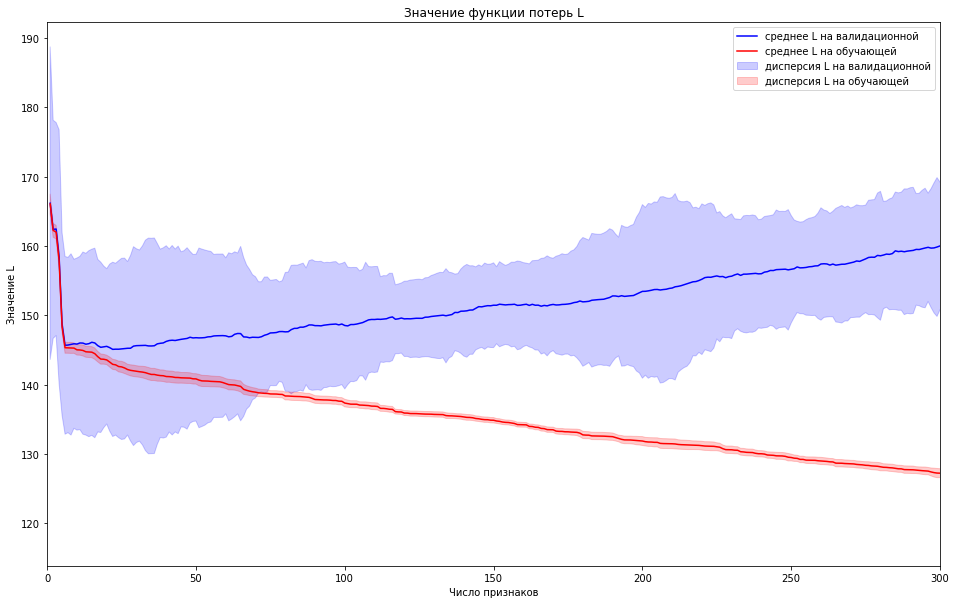

best loss: 145.0906772114917 with 22 features


In [67]:
import matplotlib.pyplot as plt

%matplotlib inline
grid = np.arange(1, max_features + 1)
plt.figure(figsize=(16, 10))
plt.plot(grid, results_test.mean(axis=1), label="среднее L на валидационной", color='blue')
test_std = results_test.var(axis=1)
plt.fill_between(grid,
                 results_test.mean(axis=1) - test_std/2,
                 results_test.mean(axis=1) + test_std/2,
                 color='blue', alpha=0.2, label="дисперсия L на валидационной")

plt.plot(grid, results_train.mean(axis=1), label="среднее L на обучающей", color='red')
train_std = results_train.var(axis=1)
plt.fill_between(grid,
                 results_train.mean(axis=1) - train_std/2,
                 results_train.mean(axis=1) + train_std/2,
                 color='red', alpha=0.2, label="дисперсия L на обучающей")
plt.title("Значение функции потерь L")
plt.xlabel('Число признаков')
plt.ylabel('Значение L')
plt.legend()
plt.xlim((0, 300))
plt.show()
pos = results_test.mean(axis=1).argmin()
print("best loss: {} with {} features".format(results_test.mean(axis=1)[pos], pos + 1))

Таким образом, оптимальное число признаков -- примерно 22.

# Поиск размера выборки

In [70]:
model = linear_model.LinearRegression()

samples_test = np.zeros(len(X) - 500)
samples_train = np.zeros(len(X) - 500)
for num in tqdm(range(1, len(X) + 1 - 500)):
    X_train = X[:num, -25:]
    y_train = y[:num]

    X_test = X[-500:, -25:]
    y_test = y[-500:]

    model.fit(X_train, y_train)
    samples_test[num - 1] = mean_squared_error(model.predict(X_test), y_test)
    samples_train[num - 1] = mean_squared_error(model.predict(X_train), y_train)

100%|██████████| 3148/3148 [00:04<00:00, 672.54it/s]


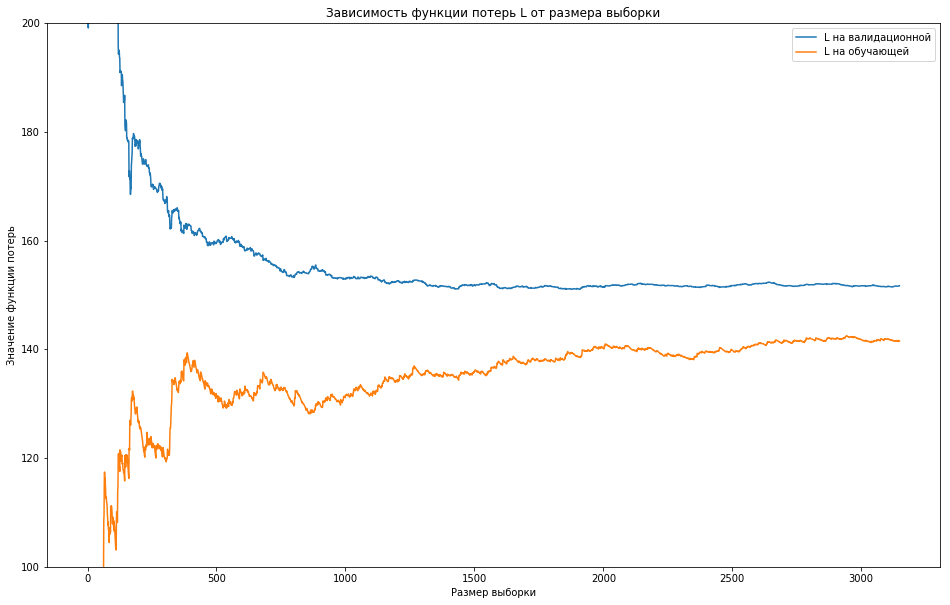

best loss: 151.04731700607326 with 1908 samples


In [74]:
grid = np.arange(1, len(X) + 1 - 500)
plt.figure(figsize=(16, 10))
plt.plot(grid, samples_test, label="L на валидационной")
plt.plot(grid, samples_train, label="L на обучающей")
plt.ylim((100, 200))
plt.title("Зависимость функции потерь L от размера выборки")
plt.xlabel("Размер выборки")
plt.ylabel("Значение функции потерь")
plt.legend()
plt.show()
pos = samples_test.argmin()
print("best loss: {} with {} samples".format(samples_test[pos], pos + 1))

Как видно по графику, функция ошибки стабилизируется при размере выборки примерно 1500

# Выводы

Наилучших результатов модель достигает при 22 признаках и размере выборки 1500.